In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()
from scipy.spatial.distance import squareform
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import DataStructs
import massspecgym.utils as utils
import json

In [5]:
df = pd.read_csv(utils.hugging_face_download("MassSpecGym.tsv"), sep="\t")

In [6]:
df.shape

(231104, 15)

In [7]:
df.groupby(['fold']).agg({'smiles': 'nunique', 'identifier': 'nunique'})

,smiles,identifier
fold,,
test,3170,17556
train,25046,194119
val,3386,19429


In [8]:
df.groupby(['adduct']).agg({'smiles': 'nunique', 'identifier': 'nunique'})

,smiles,identifier
adduct,,
[M+H]+,30388,195237
[M+Na]+,6695,35867


In [23]:

top_k_ces = df['collision_energy'].value_counts().index[:5]
#smiles_vc = df['smiles'].value_counts()
smiles_vc = df['smiles'].value_counts()

def simple_ce(ce):
    if pd.isnull(ce):
        return 'none'
    if ce in top_k_ces:
        return str(ce)
    return 'other'

def simple_smiles_count(smiles):
    c = smiles_vc[smiles]
    if c <= 5:
        return '(0, 5]'
    elif c > 100:
        return '(100, inf)'
    return '(5, 100]'

def count_peaks(row):
    return len(row['mzs'].split(','))

def get_mz_range(row):
    mzs = list(map(float, row['mzs'].split(',')))
    return max(mzs) - min(mzs)
    
def stratification_group(row):
    return str(row['adduct']) + \
        str(row['instrument_type']) + \
        str(simple_ce(row['collision_energy'])) + \
        str(simple_smiles_count(row['smiles']))
df['stratification_group'] = df.apply(stratification_group, axis=1)
df['peak_counts'] = df.apply(count_peaks, axis=1)
df['mz_range'] = df.apply(get_mz_range, axis=1)
df['stratification_group'].value_counts()

stratification_group
[M+H]+ITFTnone(5, 100]          37555
[M+Na]+ITFTnone(5, 100]         21223
[M+H]+QTOFother(5, 100]         17604
[M+H]+ITFTother(5, 100]         16213
[M+H]+QFTother(5, 100]          12467
                                ...  
[M+H]+nan10.0(0, 5]                 1
[M+H]+nan30.0(0, 5]                 1
[M+H]+Orbitrap10.0(100, inf)        1
[M+Na]+nannone(100, inf)            1
[M+Na]+Orbitrapother(5, 100]        1
Name: count, Length: 135, dtype: int64

In [26]:
set(df_plot['collision_energy'].tolist())

{'10.0', '20.0', '30.0', '45.0', '60.0', 'none', 'other'}

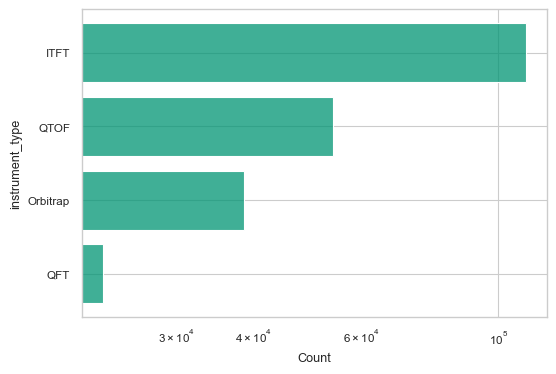

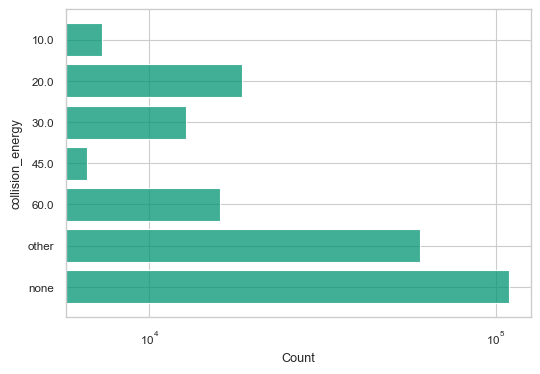

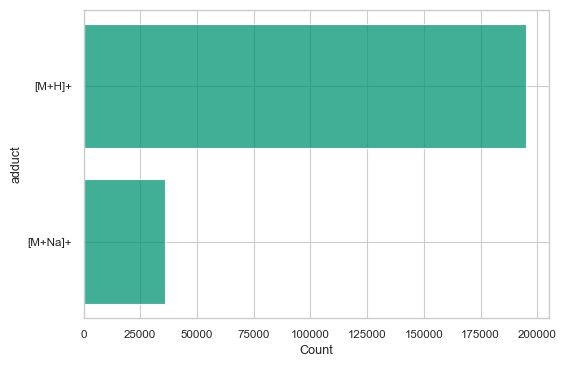

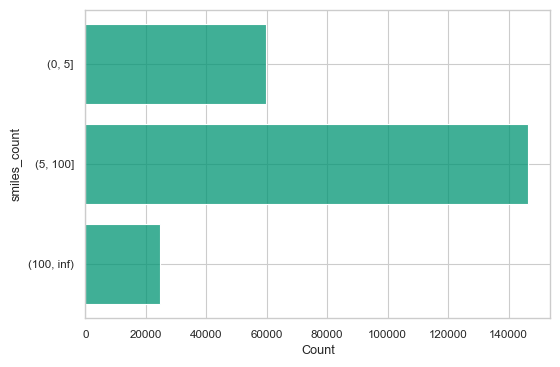

In [27]:
utils.init_plotting(figsize=(6, 4))
df_plot = df.copy()
df_plot['instrument_type'] = df_plot['instrument_type'].str.replace('Q Exactive Focus Hybrid Quadrupole Orbitrap Mass Spectrometer (Thermo Fisher Scientific)', 'Q Exactive')
df_plot['collision_energy'] = df_plot['collision_energy'].apply(simple_ce)
df_plot['smiles_count'] = df_plot['smiles'].apply(simple_smiles_count)

sns.histplot(y='instrument_type', data=df_plot, multiple='dodge', discrete=True, shrink=.8)
plt.xscale('log')
plt.savefig("../instr.png", dpi = 300.0, format="png", bbox_inches='tight')
plt.show()

df_plot['collision_energy'] = pd.Categorical(df_plot['collision_energy'], ['10.0', '20.0', 
                                                                           '30.0', '45.0',
                                                                          '60.0', 'other', 'none'])
sns.histplot(y='collision_energy', data=df_plot, multiple='dodge', discrete=True, shrink=.8)
plt.xscale('log')
plt.savefig("../ce.png", dpi = 300.0, format="png", bbox_inches='tight')
plt.show()

sns.histplot(y='adduct', data=df_plot, multiple='dodge', discrete=True, shrink=.8)
# plt.xscale('log')
plt.savefig("../adduct.png", dpi = 300.0, format="png", bbox_inches='tight')
plt.show()

df_plot['smiles_count'] = pd.Categorical(df_plot['smiles_count'], ['(0, 5]', '(5, 100]', '(100, inf)'])
sns.histplot(y='smiles_count', data=df_plot, multiple='dodge', discrete=True, shrink=.8)
plt.savefig("../smiles.png", dpi = 300.0, format="png", bbox_inches='tight')
plt.show()

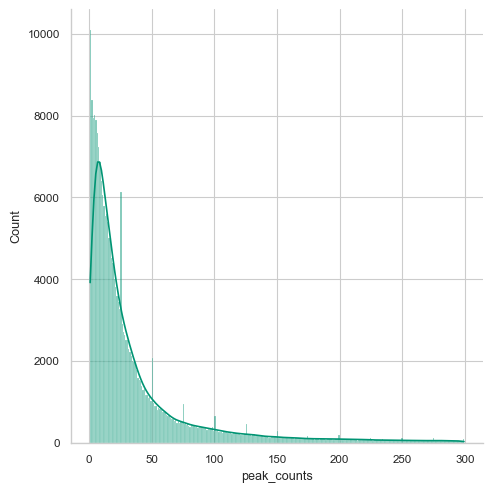

In [28]:
sns.displot(data=df_plot, x="peak_counts", kde=True)
plt.savefig("../peak_counts.png", dpi = 300.0, format="png", bbox_inches='tight')
plt.show()

In [29]:
print(df_plot['peak_counts'].mean())

36.48863282331764


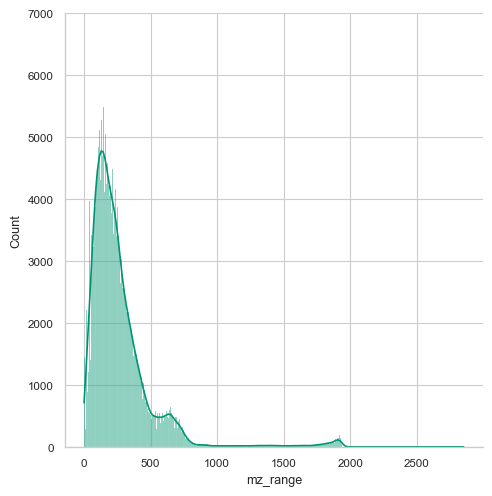

In [30]:
sns.displot(data=df_plot[df_plot['mz_range'] != 0], x="mz_range", kde=True)
plt.ylim(0,7000)
plt.savefig("../mz_range.png", dpi = 300.0, format="png", bbox_inches='tight')
plt.show()

In [31]:
print(df['mz_range'].mean())

263.11216615435825


In [32]:
from huggingface_hub import hf_hub_download
def hugging_face_download_cand(file_name: str) -> str:
    """
    Download a file from the Hugging Face Hub and return its location on disk.

    Args:
        file_name (str): Name of the file to download.
    """
    return hf_hub_download(
        repo_id="roman-bushuiev/MassSpecGym",  # TODO: not beta
        filename="data/molecules/" + file_name,
        repo_type="dataset",
    )


In [33]:
f = open(hugging_face_download_cand("MassSpecGym_retrieval_candidates_formula.json"), "rb")
cand_dict_form = json.load(f)
f.close()

(…)pecGym_retrieval_candidates_formula.json:   0%|          | 0.00/371M [00:00<?, ?B/s]

In [34]:
f = open(hugging_face_download_cand("MassSpecGym_retrieval_candidates_mass.json"), "rb")
cand_dict_mass = json.load(f)
f.close()

(…)ssSpecGym_retrieval_candidates_mass.json:   0%|          | 0.00/455M [00:00<?, ?B/s]

In [36]:
smiles_list = df['smiles'].tolist()

In [37]:
cand_counts_form = {k: len(v) for k,v in cand_dict_form.items() if k in smiles_list}
cand_pd_form = pd.DataFrame(cand_counts_form.items(), columns=['Target', 'Number of Candidates'])

In [38]:
cand_counts_mass = {k: len(v) for k,v in cand_dict_mass.items() if k in smiles_list}
cand_pd_mass = pd.DataFrame(cand_counts_mass.items(), columns=['Target', 'Number of Candidates'])

In [39]:
cand_pd_form['Number of Candidates'].sum()

6769141

In [40]:
cand_pd_form['Number of Candidates'].mean()

214.1997658376052

In [41]:
cand_pd_mass['Number of Candidates'].sum()

8020325

In [42]:
cand_pd_mass['Number of Candidates'].mean()

253.7916903993418